# Feature Extraction
This notebook uses different methods to extract features from the EMG signals.

In [1]:
# import all the libraries we need
import os
from skimage import util

import matplotlib.pyplot as plt
import pandas as pd
from numpy import linspace, where
from scipy.signal import periodogram
from scipy.integrate import cumtrapz
import numpy as np
import re
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import struct
import tsfresh
import neurokit2 as nk
import pywt
from tsfresh import extract_features
from scipy import signal, ndimage
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, NoNorm
from matplotlib.cm import get_cmap
import sys
from scipy.integrate import cumtrapz
from scipy.signal import welch,butter, filtfilt
%load_ext autoreload
%autoreload 2


In [2]:
# OpenSignals Tools own package for loading and plotting the acquired data
import biosignalsnotebooks as bsnb
import biosignalsnotebooks.signal_samples as bsnb_ss

In [7]:
os.chdir('utils/')
from utils import extract_signal, extract_fatigue
from utils import mtFeatureExtraction, stFeatureExtraction2, createSpectrogramFile
from utils import feature_extraction_wpd

ModuleNotFoundError: No module named 'cv2'

In [9]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 MB 5.3 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

In [6]:
# set the working directory
os.chdir(sys.path[0])

In [187]:
# get subfolders i.e. one for each muscle
subfolders = [f.path for f in os.scandir('Muscle Data/muscle_data/') if f.is_dir()]
print(subfolders)

['Muscle Data/muscle_data/Vastus Lateralis Left', 'Muscle Data/muscle_data/Vastus Lateralis Right', 'Muscle Data/muscle_data/Biceps Brachii Left', 'Muscle Data/muscle_data/Biceps Brachii Right']


In [188]:
# read in each dataset
df = pd.DataFrame()
for folder in subfolders:
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".h5")]
    df_muscle = pd.DataFrame(list(map(extract_signal,files)))
    df_muscle.rename(columns={0:'year',1:'month',2:'day',3:'hour',4:'minute',5:'signal',6:'sr',7:'time'},inplace=True)
    df_muscle['date'] = pd.to_datetime(df_muscle[['year', 'month', 'day']])
    df_muscle['muscle'] = folder
    df = pd.concat([df,df_muscle])

In [189]:
# create unique id for each measurement
df['id'] = range(0,df.shape[0])
df = df.reset_index()

In [190]:
# time of day indicator
df['time_of_day'] = np.where(df['hour'] > 12, 'PM', 'AM')

In [191]:
# get length of each measurement
times = []
for i in range(df.shape[0]):
   times.append(df['time'][i][len(df['time'][i])-1])
    #print(len(df['signal'][i])/df['sr'])

In [192]:
# get min and max measurement length
print(np.min(times))
print(np.max(times))

16.65
28.05


In [24]:
# save 
df.to_csv('data/concated_data.csv')

# General Parameters

In [193]:
# get sampling frequency, i.e. number of samples obtained in one second
samplingFrequency = df['sr'][0]

# short-term window size
stWindowSize = 0.25*samplingFrequency
#short-term overlap
stStep = stWindowSize

# mid-term window size
mtWindowSize = 2*samplingFrequency
mtStep = mtWindowSize - 1*samplingFrequency

# Biosignals Notebooks

## Median Power Frequency
Extract "fatigue" measure i.e. median power frequency as described in the "Fatigue Evaluation - Evolution of Median Power Frequency" Notebook from biosignals: http://notebooks.pluxbiosignals.com/notebooks/Categories/Pre-Process/emg_fatigue_evaluation_median_freq_rev.html


In [27]:
median_freq_data = pd.DataFrame(list(map(extract_fatigue,df['signal'],np.repeat(samplingFrequency,df.shape[0]))))
median_freq_data = median_freq_data.rename(columns={0:'mean_median_freq',1:'max_median_freq',2:"median_freq_list"})

In [28]:
median_freq_data['id']=median_freq_data.index

In [52]:
median_freq_data.to_csv('data/features_biosignals_fatigue.csv')

## EMG Analysis Parameter Extraction Bitalino 

Get features like described in http://notebooks.pluxbiosignals.com/notebooks/Categories/Extract/emg_parameters_rev.html

In [75]:
# calculate number of bursts
fs = df['sr'][0]
bursts = []
for i in range(df.shape[0]):
    signal = df['signal'][i]
    burst_begin, burst_end = bsnb.detect_emg_activations(signal,fs, smooth_level=20, threshold_level=10, 
                                                     time_units=True)[:2]
    # Bursts Duration
    bursts_time = burst_end - burst_begin

    # Parameter extraction
    max_time = max(bursts_time)
    min_time = min(bursts_time)
    avg_time = np.average(bursts_time)
    std_time = np.std(bursts_time)

    # Sample Stats
    # Maximum
    max_sample_value = max(signal)
    # Minimum
    min_sample_value = min(signal)

    # Average and Standard Deviation
    avg_sample_value = np.average(signal)
    std_sample_value = np.std(signal)

    # Root Mean Square
    rms = np.sqrt(sum(signal * signal) / len(signal))

    # Area under the curve
    area = cumtrapz(signal)[-1]

    # Signal Power Spectrum
    f, P = welch(signal, fs=fs, window='hamming', noverlap=0, nfft=int(256.))

    # Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
    area_freq = cumtrapz(P, f, initial=0)
    total_power = area_freq[-1]
    median_freq = f[where(area_freq >= total_power / 2)[0][0]]
    f_max = f[np.argmax(P)]
    bursts.append([len(burst_begin),avg_time, max_time,min_time,std_time,
                   avg_sample_value,max_sample_value, min_sample_value, std_sample_value,
                   area, total_power, median_freq,f_max])

In [80]:
bitalino_features = pd.DataFrame(bursts).rename(columns ={0:'bursts_count',1:'avg_time',2:'max_time',3:'min_time',4:'std_time',
                                      5:'avg_sample_value',6:'max_sample_value',7:'min_sample_value',8:'std_sample_value',
                                      9:'area',10:'total_power',11:'median_freq',12:'f_max'})

In [81]:
bitalino_features

,bursts_count,avg_time,max_time,min_time,std_time,avg_sample_value,max_sample_value,min_sample_value,std_sample_value,area,total_power,median_freq,f_max
0,5,1.337065,1.725083,1.054051,0.222156,513.242802,637,411,12.725067,10623611.5,162.424949,70.31250,54.68750
1,8,1.409562,2.473108,0.061003,0.803372,513.227149,566,443,6.108840,11701067.0,37.157295,58.59375,39.06250
2,6,1.230554,2.472108,0.222010,0.944896,513.184649,571,388,6.834332,11700096.5,50.032507,50.78125,42.96875
3,5,1.187854,1.460067,0.597027,0.302602,513.163790,591,466,5.328700,11237773.0,33.513427,50.78125,50.78125
4,6,0.827707,1.008049,0.319016,0.233982,513.167445,796,335,25.195439,10545078.5,655.094083,74.21875,74.21875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,6,0.778036,1.163054,0.631029,0.176885,513.229120,812,318,23.038393,11085229.5,539.035878,89.84375,78.12500
156,5,1.095851,1.383064,0.935044,0.169552,513.180513,804,267,26.101860,11007199.5,710.909499,58.59375,50.78125
157,10,0.777136,1.001047,0.441021,0.162365,513.186713,819,285,40.075110,11007325.0,1635.064279,54.68750,50.78125
158,6,1.396726,1.701072,1.156049,0.175852,513.184289,635,364,13.482709,12084977.5,191.773627,82.03125,74.21875


In [82]:
bitalino_features.to_csv('data/features_biosignals.csv')

## Papakostas et al 2019

Michalis Papakostas, Varun Kanal, Maher Abujelala, Konstantinos Tsiakas, and Fillia Makedon. 2019. Physical fatigue detection through EMG wearables and subjective user reports: a machine learning approach towards adaptive rehabilitation. In Proceedings of the 12th ACM International Conference on PErvasive Technologies Related to Assistive Environments (PETRA '19). Association for Computing Machinery, New York, NY, USA, 475–481. https://doi.org/10.1145/3316782.3322772

Protocol: 
- perform exercise (3 exercises; shoulder flexion (SF), shoulder abduction (SA) and elbow extension (EE)) using Barret WAM arm (give feedback force)
- push against resistor as long as possible
- when feeling fatigued -> tell experimenter (who marks the time point)
- hold for 10 more seconds
- go back to starting position

3 repetitions of each exercise with short breaks in between


Link to Github Repo: https://github.com/MikeMpapa/MLEmg_Monitoring_Physical_Fatigue/tree/master

They predict subjective fatigue as reported by the patient while performing arm exercises

Data:
Sampling frequency: 1926HZ. 
filtered the signal using the median filtering technique with a window size of 11 samples



They extract two types of features:
- Short-term features based on non-overlapping windows with a length of 0.25 seconds
    - Minimum
    - Maximum
    - Standard Deviation
    - Mean
    - Spectral Minimum
    - Spectral Maximum
    - Spectral Standard Deviation
    - Spectral Mean
    - Spectral Entropy
    - Spectral Flux
    - Zero Crossing Rate
    - Energy Entropy
    - Wilson Amplitude (WAMP)
    - for each of the above compute delta between the present set of features and the set of features extracted from the preceeding window
- Mid-term features based on overlapping windows with a length of 2 seconds and a window step of 1 
    - each set of 8 successive short-term feature vectors is described using the minimum, maximum, standard devation and mean information extracted from the short-term feature

Features that were tested in the paper but ommitted:
- singal energy
- spectral spread (i.e. the second central moment of the spectrum)
- spectral rolloff (i.e. the frequency below wihcih 90% of the magnitude distribution of the spectrum is concentrated)
- spectral centroid (teh center of gravity of the spectrum)

Models: Linear SVM, SVM with an RBF Kernel, Gradient-Boosting (GB), Extra-Trees (ET) and Random Forests (RF).
-> results vary across tests, for  single user evaluation ET is strongeest (78%)
Fatigue is binary 0/1
They also apply some post-processing


In [144]:
#stFeatures = stFeatureExtraction2(df['signal'][0], samplingFrequency, stWindowSize, stStep)

In [194]:
# extract midterm features for all observations
all_features = pd.DataFrame()
for i in range(df.shape[0]):
    id = i
    mtFeatures = mtFeatureExtraction(df['signal'][i],samplingFrequency, mtWindowSize, mtStep, stWindowSize, stStep)
    output_i = pd.DataFrame(mtFeatures[0].T)
    output_i['id'] = i
    all_features = pd.concat([all_features, output_i])

In [ ]:
createSpectrogramFile()

In [50]:
all_features

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,id
0,-7.367802,11.257198,2.993252,-0.044302,0.012164,1.619524,0.265621,0.258904,2.701189,0.006444,...,-0.011017,-1.456321,-0.390927,-0.117176,-1.245641,-0.001155,-0.172691,-0.610548,-14.0,0
1,-13.867802,22.757198,6.179139,0.003698,0.018655,3.254332,0.590084,0.506903,2.164882,0.009452,...,-0.011017,-2.319506,-0.445464,-0.179406,-1.245641,-0.006188,-0.172691,-0.610548,-14.0,0
2,-14.242802,25.257198,6.214167,0.003198,0.022193,3.041578,0.589974,0.514698,2.191359,0.008647,...,-0.018496,-3.777086,-0.745014,-0.523571,-1.129969,-0.006188,-0.064257,-1.353293,-15.0,0
3,-15.867802,25.757198,5.779052,-0.173802,0.029897,3.353535,0.561256,0.461473,2.312994,0.008795,...,-0.018496,-3.777086,-0.745014,-0.523571,-1.129969,-0.004569,-0.084337,-1.353293,-15.0,0
4,-34.492802,41.757198,12.802192,0.045198,0.045004,6.601445,1.221991,1.060090,2.244225,0.008577,...,-0.037423,-4.954542,-0.735329,-0.481952,-0.808355,-0.011090,-0.084337,-0.858348,-2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,-17.242802,20.007198,6.117595,0.004698,0.020073,3.472263,0.574748,0.511668,2.329024,0.008643,...,-0.015582,-2.196330,-0.312614,-0.242181,-1.529928,-0.005072,-0.196787,-0.311140,-15.0,159
17,-28.617802,34.507198,10.515058,0.013698,0.031451,5.548660,0.973807,0.899037,2.281642,0.008215,...,-0.025126,-3.571943,-0.661200,-0.488952,-1.529928,-0.009928,-0.196787,-0.497930,-22.0,159
18,-21.117802,24.132198,7.483847,0.004698,0.026393,3.766811,0.671992,0.664421,2.432037,0.006207,...,-0.025126,-3.571943,-0.661200,-0.488952,-0.383153,-0.009928,-0.024096,-0.497930,-22.0,159
19,-5.076135,6.257198,1.902542,-0.038802,0.011689,0.903047,0.150830,0.186223,2.726541,0.006701,...,-0.013714,-1.088317,-0.233659,-0.213026,-0.301979,-0.002066,-0.052209,-0.095461,-22.0,159


In [195]:
all_features.to_csv('/Users/htr365/Documents/Side_Projects/09_founding_lab/amanda_johanna/quantified_self/data/features_papakostas.csv')

## Kefalas, 2023
Kefalas, M. (2023, January 19). Data-driven predictive maintenance and time- series applications. Retrieved from https://hdl.handle.net/1887/3511983

They use the python-package tsfresh to extract time series features from the signals. This, per default extracts 1,200 time series features.
https://tsfresh.readthedocs.io/en/latest/text/quick_start.html
They define traces of 0.2s and stitch them together to 5s observations. If the measurement time was longer they only take the last 5s.

They use a random forest model.


I am not entirely sure if this is also what they did but I first calculate mean value over 0.25s (to be consistent with the one before and 0.2 vs. 0.25 shouldn't make much difference) before feature extraction.

In [23]:
samplingFrequency*0.25

250.0

In [28]:
pd.Series(df.iloc[0]['signal']).rolling(window=int(0.25*samplingFrequency)).mean().dropna()

249      513.196
250      513.188
251      513.188
252      513.188
253      513.188
          ...   
20695    513.168
20696    513.176
20697    513.184
20698    513.184
20699    513.184
Length: 20451, dtype: float64

In [31]:
window_size=250

In [40]:
def calculate_mean(data, start_index):
    window_data = data[start_index:start_index+window_size]
    return window_data.mean()
#pd.Series(df.iloc[0]['signal']).aggregated_means

In [55]:
# extract midterm features for all observations
all_features = pd.DataFrame()
for i in range(df.shape[0]):
    id = i
    df_sub = pd.DataFrame(df['signal'][i]).reset_index().rename(columns={0:'value'})
    # aggreagte per 0.25 s
    aggregated_means=[]
    for j in range(0, df_sub.shape[0], window_size):
        aggregated_means.append(calculate_mean(df_sub['value'],j))
    aggregated_means = pd.DataFrame(aggregated_means).reset_index().rename(columns={0:'value'})
    output_i = extract_features(aggregated_means, column_id='index')
    output_i = pd.DataFrame(output_i)
    output_i['id'] = i
    all_features = pd.concat([all_features, output_i])

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.95it/s]


In [56]:
all_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7,id
0,0.0,0.0,0.0,0.0,513.196,263370.134416,NaN,NaN,NaN,513.196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.0,0.0,0.0,0.0,513.160,263333.185600,NaN,NaN,NaN,513.160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.0,0.0,0.0,0.0,513.208,263382.451264,NaN,NaN,NaN,513.208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.0,0.0,0.0,0.0,513.216,263390.662656,NaN,NaN,NaN,513.216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0.0,0.0,0.0,0.0,513.148,263320.869904,NaN,NaN,NaN,513.148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.0,0.0,0.0,0.0,513.024,263193.624576,NaN,NaN,NaN,513.024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159
74,0.0,0.0,0.0,0.0,513.040,263210.041600,NaN,NaN,NaN,513.040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159
75,0.0,0.0,0.0,0.0,513.140,263312.659600,NaN,NaN,NaN,513.140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159
76,0.0,0.0,0.0,0.0,513.236,263411.191696,NaN,NaN,NaN,513.236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159


In [62]:
# drop columns that contain only na
all_features = all_features.dropna(axis=1, how='all')

In [63]:
all_features.to_csv('/Users/htr365/Documents/Side_Projects/09_founding_lab/amanda_johanna/quantified_self/data/features_kefalas.csv')

## Jaiswal, 2022

Very little information on specific features used, EMG feature extraction based on Neurokit2. Provides 6 features for EMG.
https://github.com/neuropsychology/NeuroKit

They use a random forest model

In [13]:

# extract midterm features for all observations
all_features = pd.DataFrame()
for i in range(df.shape[0]):
    id = i
    df_sub = pd.DataFrame(df['signal'][i])
    output_i = nk.bio_process(emg=df['signal'][i], sampling_rate=samplingFrequency)
    output_i = output_i[0]
    output_i['id'] = i
    all_features = pd.concat([all_features, output_i])


In [14]:
all_features

,EMG_Raw,EMG_Clean,EMG_Amplitude,EMG_Activity,EMG_Onsets,EMG_Offsets,id
0,515,-0.015398,-0.167870,0.0,0,0,0
1,512,-2.497818,-0.077191,0.0,0,0,0
2,513,-1.029911,0.012154,0.0,0,0,0
3,514,0.365144,0.099934,0.0,0,0,0
4,513,-0.295427,0.185939,0.0,0,0,0
...,...,...,...,...,...,...,...
19495,516,-0.232632,3.361213,0.0,0,0,159
19496,515,0.049431,3.349859,0.0,0,0,159
19497,512,-0.674427,3.339172,0.0,0,0,159
19498,513,3.414870,3.329267,0.0,0,0,159


In [75]:
all_features.to_csv('/Users/htr365/Documents/Side_Projects/09_founding_lab/amanda_johanna/quantified_self/data/features_jaiswal.csv')

## Feature Extraction based on Yaman, 2019

They use wavelet packet decomposition

My code is based on: https://www.kaggle.com/code/pluceroo/new-approach-wavelet-packet-decomposition-in-ml



In [152]:
yaman_features =[]
for i in range(df.shape[0]):
    features = feature_extraction_wpd(df['signal'][i],4,samplingFrequency)[0]
    yaman_features.append(features)

In [155]:
pd.DataFrame(yaman_features).to_csv('data/features_yaman.csv')

## Venugopal 2014

The mean removed signal is
filtered using a Butterworth band pass filter of range of 20–
400 Hz and a notch filter of 50 Hz (De Luca, Donald, Mikhail, &
Serge, 2010).

A differential electrode configuration is used, with the distance between two electrodes equal to 3 cm 

They record 2s before and after the exercise -> i.e. take the first and last 2s from our measurements?

In [161]:
def butter_bandpass(lowcut, highcut, fs, order=5):
   nyq = 0.5 * fs
   low = lowcut / nyq
   high = highcut / nyq
   b, a = butter(order, [low, high], btype='band')
   return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
   b, a = butter_bandpass(lowcut, highcut, fs, order=order)
   y = filtfilt(b, a, data)
   return y

In [172]:
# remove mean
sg = df['signal'][0]- - np.mean(df['signal'][0])
f1 = 20
f2 = 400
order = 4

filtered = butter_bandpass_filter(sg, f1, f2, fs, order)
len(filtered)
Q=60
b, a = signal.iirnotch(50, Q, fs)
freq, h = signal.freqz(b, a, fs=fs)


In [182]:
# get number of 2s segements in the signal (that is what they do in the paper?)
intervals = np.round(df['signal'][0].shape[0]/fs/2)

10.0

In [176]:
M=512
slices = util.view_as_windows(df['signal'][i], window_shape =(M,), step=64)

window = signal.windows.hamming(M)
window*slices


array([[40.8       , 41.13787325, 41.27162937, ..., 41.27162937,
        41.13787325, 40.96      ],
       [40.96      , 41.21790802, 41.27162937, ..., 41.11135119,
        41.29794279, 41.36      ],
       [41.2       , 40.9778037 , 41.27162937, ..., 41.03121211,
        41.13787325, 41.12      ],
       ...,
       [41.2       , 40.9778037 , 40.95107302, ..., 40.95107302,
        40.9778037 , 41.12      ],
       [40.64      , 40.81773415, 41.11135119, ..., 41.03121211,
        40.9778037 , 41.44      ],
       [41.12      , 40.65766461, 41.03121211, ..., 40.95107302,
        41.21790802, 41.52      ]])

## Feature extraction based on Kumar, 2022

P. Kumar, S. K. V, M. C. Lakkannavar and V. C. R, "Comparison of Machine Learning Algorithms for EMG based Muscle Function Analysis," 2022 4th International Conference on Circuits, Control, Communication and Computing (I4C), Bangalore, India, 2022, pp. 123-128, doi: 10.1109/I4C57141.2022.10057856.

they try to predcit neck pain best on EMG measures of neck muscles

16 time domain features - not all of them seem to be reported, generally bit of a weird paper (bad English)
- slope sign change (SSC), 'quantity of variation in the slope of the EMG waeform that occur withn an analysis frame'
- mean absolute value (MAV)
- simple square integral (SSI)
- average amplitude change (AAC)
- Myopulse percentage rate
- enhanced wavelength (EW)
- Wavelength amplitude(WA)

they train a support vector machine, k nearest neighbors, random forest, decision tree, naive bayes classifier and logistic regression -> max accuracy is 91.6%
random forest and SVM seem to be best?!

## Feature extraction based on Tannemaat, 2023
they aim to distinguish normal, neuropathic and myopathic electromyography (EMG) traces

-> Kefalas is a co-author on this, they use the same appraoch, i.e. tsfresh

## Golmohammadsihouraki, 2022

aim to predict the onset of fatigue in people doing squats (binary)

MNF  = mean frequency
MDF = median frequency
EMG features: 
- Average MNF
- Slope MNF
- Intercept MNF
- Average MDF
- Slope MDF
- Intercept MDF

those are calculated per bin, where 1 bin is a set of quats 

test 5 different ML models -> random forest performs best (5 fold cross validation) - accuracy of 0.85



# Afram, Sabet 2023
goal is to predict level of fatigue after excerise with 7 levels

- mean frequency
- median frequency
- root mean square
- average rectified value
- area under the power spectral density
- area under the power spectral density for specific frequencies
- dimitrov spectral parameter
- kurt D - shape of the prob. distribution of a signal
- skew D - symmetry of the prob. distribution of a sigal
- mode D - value that occurs most frequently in the signal
- mean D - average value of a signal
- std D - standard devation of a signal


Spectrogram features
-> convert to images: use pywt and scipy to convert frequency and time to CWT and STFT spectrogram images -'stft_spectrogram, cwt_spectrogram '
Morlet wavelet range from 1 to 30
window size of 512 and overlap of 128

test three 'baseline' models - decision tree, random forest, SVM -> random forest performs best, accuray of 56%


DenseNet and VGG16 gave a reliable accuracy of 89.8 % on intelligent data augmented CWT images

## Transformation to Spectrograms 
based on my own code I used for audio processing at some point: https://github.com/johanna-einsiedler/quantle_plus/blob/master/Wav_to_Spectrogram.py

according to this paper lens size 512 should work best for EMG as well

In [133]:
for i in range(df.shape[0]):
    # Lens Size
    M=512
    # cut into slices for calculating FFT
    slices = util.view_as_windows(df['signal'][i], window_shape =(M,), step=64)

    # create a window function
    win = np.hanning(M+1)[:-1]
    slices = slices * win

    # take transpose to have one slice per column
    slices = slices.T
    # print('Shape of Slices:', slices.shape)

    # for each slice calculate DFT and slice out positive values
    spectrum = np.fft.fft(slices, axis = 0)[:M // 2]
    spectrum = np.abs(spectrum)

    # Calculate length of spectrum and number of samples of length 256 in this spectrum
    N = spectrum.shape[1]
    K = round((N/(M/4))-0.5)-1


    for k in range(1,K+1):
        # slice out pieces of size 256 of the spectrum
        spectrum_slice = spectrum[:,(k-1)*128:(k+1)*128]

        # plot spectrogram
        fig = plt.figure() # create plot
        S = np.abs(spectrum_slice) # take absolute values
        S = 20 * np.log10(S / np.max(S)) # adjust data scale
        sizes = np.shape(S)  # get shape of data
        fig.set_size_inches(1. * sizes[0] / sizes[1], 1, forward=False) # set figure size
        ax = plt.Axes(fig, [0., 0., 1., 1.]) # set axis size so we don't have a border
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.imshow(S, cmap='jet')  # plot in kHz, log of spectrogram, decide on colouring

        # specify name of plot
        #name=f.split('\\')[1]

        # save figure without border to folder for respective emotion, named after the original wav File
        save_results_to = 'data/images/'
        fig.savefig(save_results_to  +str(i)+'_'+ str(k) + '.png', dpi = sizes[0])
        plt.close()

## OLD CODE

In [140]:
power, times, frequencies, coif = cwt_spectrogram(df['signal'][0],1000)

AttributeError: 'numpy.ndarray' object has no attribute 'detrend'

In [134]:
def cwt_spectrogram(x, fs, nNotes=12, detrend=True, normalize=True):
    
    N = len(x)
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x = signal.detrend(x,type='linear')
    if normalize:
        stddev = x.std()
        x = x / stddev

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
    
#     print (scales)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef, freqs=pywt.cwt(x,scales,'cmor1.5-1.0')
    frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
    
    ###########################################################################
    # power
#     power = np.abs(coef)**2
    power = np.abs(coef * np.conj(coef))
    
    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi


    return power, times, frequencies, coif

In [135]:
def spectrogram_plot(z, times, frequencies, coif, cmap=None, norm=Normalize(), ax=None, colorbar=True):
    ###########################################################################
    # plot
    
    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    xx,yy = np.meshgrid(times,frequencies)
    ZZ = z
    
    im = ax.pcolor(xx,yy,ZZ, norm=norm, cmap=cmap)
    ax.plot(times,coif)
    ax.fill_between(times,coif, step="mid", alpha=0.4)
    
    if colorbar:
        cbaxes = inset_axes(ax, width="2%", height="90%", loc=4) 
        fig.colorbar(im,cax=cbaxes, orientation='vertical')

    ax.set_xlim(times.min(), times.max())
    ax.set_ylim(frequencies.min(), frequencies.max())

    return ax

NameError: name 'cwtmatr' is not defined

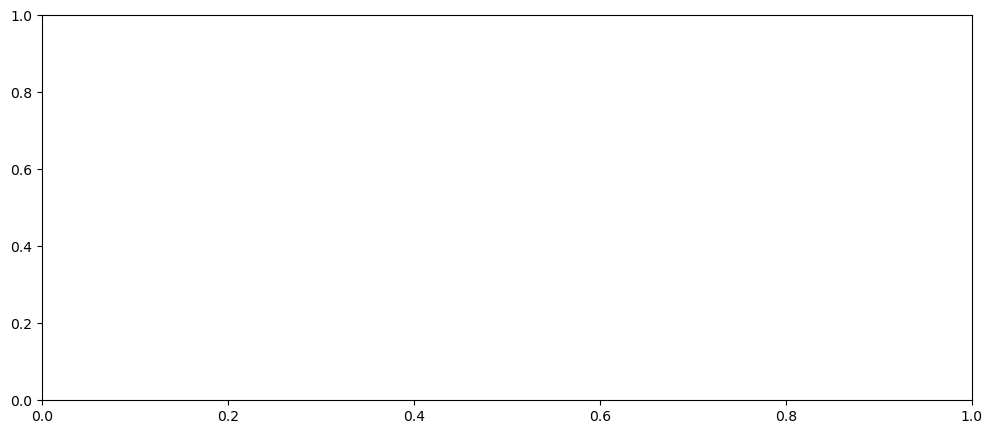

In [136]:
#imshow
fig, ax = plt.subplots(figsize=(12, 5))
imshow_ = plt.imshow(np.abs(cwtmatr), extent=[-1, 1, 1, 31], cmap='jet', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=0)  
fig.colorbar(imshow_)
#ax.set_title('Wavelet Transform of Signal (${}$)'.format(waveletname), fontsize=20)
ax.set_ylabel('Scales', fontsize=15)
ax.set_xlabel('Time', fontsize=15)
plt.show() 

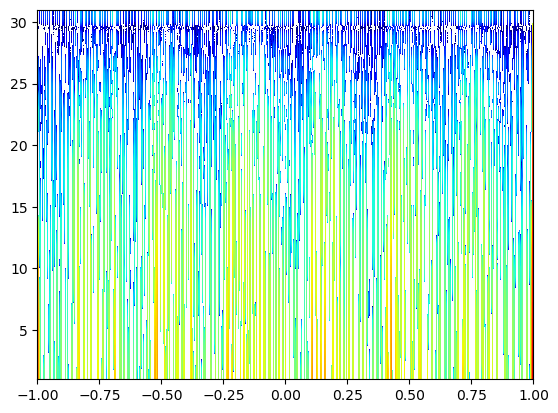

In [139]:
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(df['signal'][0], widths, 'morl')
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='jet', aspect='auto',  norm=LogNorm(),
           #vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max()
           )  
plt.show() 

/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_66529/983676038.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


NameError: name 'inset_axes' is not defined

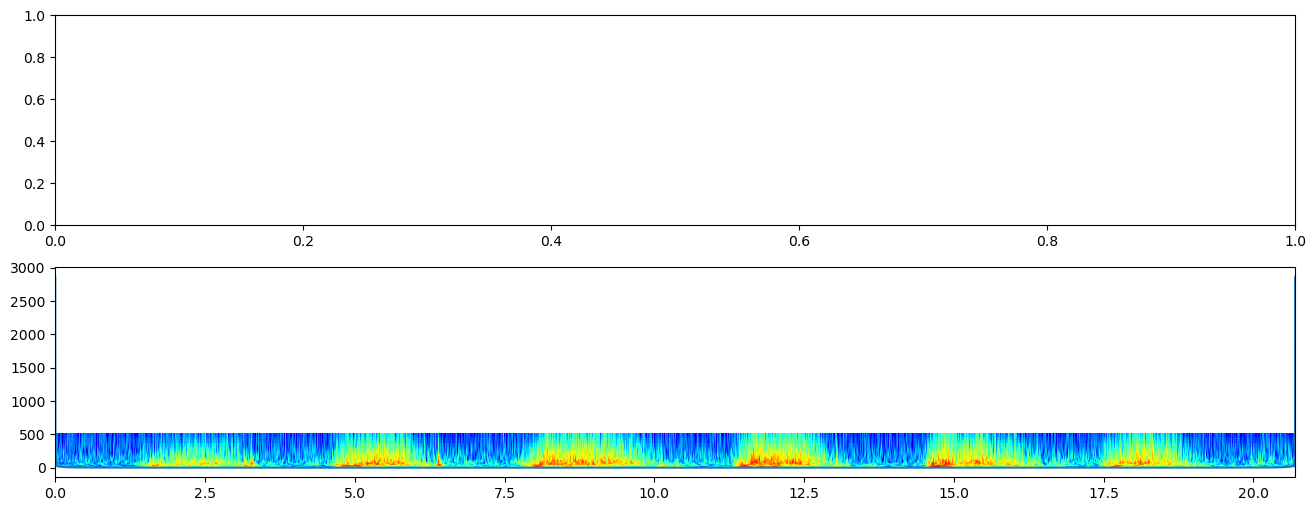

In [228]:
plt.rcParams['figure.figsize'] = (16, 6)

###########################################################################
# calculate spectrogram

#t0 = time.time()
#power, times, frequencies, coif = cwt_spectrogram(wav_data, sampling_frequency, nNotes=24)
#print (time.time()-t0)


###########################################################################
# plot
n_samples = len(df['signal'][0])

total_duration = n_samples / samplingFrequency
sample_times = np.linspace(0, total_duration, n_samples)
fig, (ax1, ax2) = plt.subplots(2, 1)

#ax1.plot(sample_times, wav_data, color='b');

#ax1.set_xlim(0, total_duration)
#ax1.set_xlabel('time (s)')
#ax1.set_ylim(-np.abs(wav_data).max()*1.2,np.abs(wav_data).max()*1.2)
#ax1.grid(True)
# ax1.axis('off')
spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), ax=ax2)

ax2.set_xlim(0, total_duration)
# ax2.set_ylim(0, 0.5*sampling_frequency)
ax2.set_ylim(2.0/total_duration, 0.5*samplingFrequency)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('frequency (Hz)');

ax2.grid(True)